## SETUP

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [225]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import itertools
import pickle

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, Imputer, OneHotEncoder, LabelEncoder
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.experimental import enable_iterative_imputer

from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC
from lime import lime_tabular

In [11]:
from gensim import corpora
from gensim.parsing.preprocessing import *
import spacy
# python -m spacy download en_core_web_sm 
import en_core_web_md
nlp = spacy.load('en_core_web_md')

In [12]:
#from helpers import *

-----

## PREPROCESSING

#### **Preprocessing setup**

In [208]:
train_csv = "train.csv"
train_json = "train.json"
test_csv = "test.csv"
test_json = "test.json"

In [54]:
# text preprocessing
custom_filters = [lambda x: x.lower(),
                  strip_tags,
                  strip_punctuation,
                  strip_multiple_whitespaces,
                  remove_stopwords]

num_columns = ['daily_commute', 'friends_number', 'education', 'age',\
               'texts_fitness_score', 'groups_count', 'days_since_last_join']

fit_words = ['gym', 'fitness', 'bike', 'weightlifting', 'squash', 'tennis',\
             'crossfit', 'bodybuilding', 'sport', 'excercise']

#### **Helpers**

In [215]:
def parse_memberships_json(json_path):
    """
    Loads json file and returns flattened long table with group membership activities
    Output format: user_id | group_name | date_joined
    """
    with open(json_path) as f:  
        dict_json = json.load(f)      
    json_df = pd.io.json.json_normalize(dict_json['data'])
    json_df.set_index('id', inplace=True)
    
    groups_activity=\
    (json_df['groups.data'].apply(pd.Series)
     .stack()
     .reset_index(level=1, drop=True)
     .to_frame('membership_events')
    )
    groups_activity['groups_name'] = groups_activity['membership_events'].apply(lambda x: x['group_name'])
    groups_activity['date_join'] = groups_activity['membership_events'].apply(lambda x: x['date_joined'])
    groups_activity.drop(['membership_events'], axis=1, inplace=True)
    groups_activity.reset_index(drop = False, inplace = True)
    groups_activity['date_join'] = pd.to_datetime(groups_activity['date_join'].str[0:10], format='%Y/%m/%d')
    return(groups_activity)


def score_similarity(doc, seed):
    # Calculates cosine distance between average of word vectors in the doc and provided template text
    nlp_doc = nlp(doc)
    return(nlp_doc.similarity(seed))


def load_data(csv_path, json_path):
    # Loads tabular and formatted json into pandas dataframe
    df = pd.read_csv(csv_path)
    input_json = parse_memberships_json(json_path)
    return(df, input_json)


def fill_gender(df):
    # Fill missing gender using last lettern in the name
    df['estimated_gender'] = np.where(df['name'].str[-1] == 'a', 'female', 'male')
    df['sex'] = np.where(df['sex'].isna(), df['estimated_gender'], df['sex'])
    return(df)


def calculate_age(df):
    # Calculate age using date of birth
    df['dob'] = pd.to_datetime(df['dob'], format='%Y/%m/%d')
    df['age'] = df['dob'].apply(lambda x: round((datetime.datetime.today() - x).days/365, 2))
    return(df)


def add_location_features(df):
    # Creates discrete buckets from location population size and checks if a user changed her/his location 
    location_sizes = ["small_loc", "medium_loc", "big_loc"]
    df['loc_size_now'] = pd.qcut(df['location_population'], 3, labels=location_sizes)
    df['loc_size_past'] = pd.qcut(df['location_from_population'], 3, labels=[l + "_past" for l in location_sizes])
    df['same_location'] = df['location'] == df['location_from']
    return(df)


def make_membership_features(input_json):
    # Calculates a count of groups a user belongs to and number of days since last group join
    groups_features =\
    (input_json
     .groupby(['id'], as_index=False)
     .agg({'groups_name': 'count', 'date_join': ['max']})
    )
    groups_features.columns = ['user_id', 'groups_count', "max_join_date"]
    groups_features['days_since_last_join'] = groups_features['max_join_date'].apply(lambda x: round((datetime.datetime.today() - x).days, 2))
    groups_features.drop(['max_join_date'], axis=1, inplace=True)
    groups_features["user_id"] = pd.to_numeric(groups_features["user_id"])
    return(groups_features)


def make_texts_table(df, input_json):
    # Joins hobbies and group names into one long dataframe
    hobbies_txt = df[['user_id', 'hobbies']]; hobbies_txt.columns = ['user_id', 'txt']
    groups_txt = input_json[['id', 'groups_name']]; groups_txt.columns = ['user_id', 'txt']
    texts_df = pd.concat([hobbies_txt, groups_txt])
    texts_df['txt'].fillna("No texts", inplace=True)
    return(texts_df)    


def clean_texts(texts_df, text_prep_filters):
    # Texts preprocessing using custom filters (lower, punctuation, whitespaces, stop words)
    raw_corpus = texts_df['txt'].to_list()
    texts = [preprocess_string(filters=text_prep_filters, s=text) for text in raw_corpus]
    joined_texts = [" ".join(text) for text in texts]
    assert(len(joined_texts) == texts_df.shape[0])
    return(joined_texts)


def find_fit_words(texts_df, joined_texts, fit_words):
    # Looks for fit related words (from provided list) in cleaned texts and creates boolean table with all users
    has_words = [[w in t for w in fit_words] for t in joined_texts]
    fit_words_df = pd.DataFrame(has_words)
    fit_words_df.columns = fit_words
    texts_df = texts_df.join(fit_words_df)
    has_words_df = texts_df.groupby(['user_id']).any().drop(['txt'], axis=1)
    return(has_words_df)


def calc_text_fit_score(texts_df, joined_texts, fit_words):
    """
    Calculates cosine distance between average of word vectors in
    user texts and provided template text (fitness related) and takes max
    """
    seed_joined = " ".join(fit_words)
    nlp = en_core_web_md.load()  #spacy
    seed_doc = nlp(seed_joined)
    texts_scores = [score_similarity(t, seed_doc) for t in joined_texts]
    texts_df['texts_fitness_score'] = texts_scores
    fitness_scores = texts_df.groupby(["user_id"]).agg({'texts_fitness_score': 'max'})
    fitness_scores.reset_index(inplace=True)
    return(fitness_scores)


def make_input_df(csv_path, json_path, num_columns, fit_words, text_prep_filters):
    """
    All non-parametric preprocessing steps to make dataframe input for sklearn pipeline:
    - loading tabular data from csv
    - loading and flattening json file
    - filling missing gender with Name (trailing 'a' -> female)
    - calculate age (today - dob)
    - extract location features:
        - 3 lvls buckets for size
        - has_changed
    - extract group membership features:
        - number of groups
        - number of days since last time joined a group
    - extract text features (from hobbies + group_names):
        - binary - includes top 10 fitness related words
        - "text fitness score" - how fit related is given text
    """
    
    # Core features
    df, input_json = load_data(csv_path, json_path)
    df = fill_gender(df)
    df = calculate_age(df)
    df = add_location_features(df)
    
    # Group features
    groups_features = make_membership_features(input_json)
    df = df.merge(groups_features, on="user_id", how="left")
    
    # Text features
    texts_df = make_texts_table(df, input_json)
    joined_texts = clean_texts(texts_df, text_prep_filters)
    has_fit_words = find_fit_words(texts_df, joined_texts, fit_words)
    df = df.join(has_fit_words, on="user_id", how="left")
    
    fitness_scores = calc_text_fit_score(texts_df, joined_texts, fit_words)
    df = df.merge(fitness_scores, on='user_id', how="left")
    
    # Clean output
    df[["same_location"] + fit_words] = df[["same_location"] + fit_words].replace(True, pd.Series(df.columns, df.columns))
    df[["same_location"] + fit_words] = df[["same_location"] + fit_words].replace(False, pd.Series("not_" + df.columns, df.columns))
    df.drop(['dob', 'location', 'location_population', 'location_from',\
         'location_from_population', 'estimated_gender', 'name'], axis=1, inplace=True)
    df[num_columns] = df[num_columns].apply(pd.to_numeric)
    
    return(df)
    

#### **Make development dataframe**

In [217]:
%%time
df = make_input_df(csv_path=train_csv,
                   json_path=train_json,
                   num_columns=num_columns,
                   fit_words=fit_words,
                   text_prep_filters=custom_filters)

CPU times: user 2min 47s, sys: 356 ms, total: 2min 48s
Wall time: 2min 48s


In [58]:
df.head().T

,0,1,2,3,4
user_id,0,1,2,3,4
target,1,0,1,0,0
sex,female,male,male,female,male
occupation,Teaching professionals,General and keyboard clerks,Protective services workers,Customer services clerks,Refuse workers and other elementary workers
hobbies,Fitness,"LARPing,Foreign language learning,Netball","Bodybuilding,Kabaddi",Badminton,"Fitness,Embroidery,Lacemaking"
daily_commute,46,55,90,88,40
friends_number,196,243,191,164,119
relationship_status,Single,Single,In relationship,In relationship,Married with kids
education,NaN,NaN,3,3,5
credit_card_type,Visa,NaN,NaN,Visa,NaN


#### **Make development arrays**

In [71]:
y_dev = df['target'].values
x_df = df.drop(['user_id', 'target', 'occupation', 'hobbies'], axis=1)
all_columns = x_df.columns
cat_columns = list(set(all_columns) - set(num_columns))

In [72]:
num_pipe = Pipeline([
    ('simple_imputer', Imputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('con_imputer', SimpleImputer(strategy='constant', fill_value='misasing')),
    ('one_hot', OneHotEncoder())
])

full_pipe = ColumnTransformer(
    transformers=[
    ('num_pipe', num_pipe, num_columns),
    ('cat_pipe', cat_pipe, cat_columns)
])

In [75]:
X_dev = full_pipe.fit_transform(x_df)
print(x_dev.shape)

(4000, 47)


----

## MODELING

#### **Choose model**

In [96]:
%%time
models = [LogisticRegression, RandomForestClassifier, GradientBoostingClassifier]
all_scores = []
for m in models:
    model = m()
    model_scores = []
    k_fold = RepeatedKFold(n_splits=5, n_repeats=10, random_state=23)
    for train_index, val_index in k_fold.split(X_dev):
        X_train, X_val = X_dev[train_index], X_dev[val_index]
        y_train, y_val = y_dev[train_index], y_dev[val_index]
        model.fit(X = X_train, y = y_train)
        preds = model.predict(X_val)
        score_test = f1_score(y_val, preds, average = 'macro')
        model_scores.append(score_test)
    all_scores.append(model_scores)

CPU times: user 28.5 s, sys: 164 ms, total: 28.7 s
Wall time: 25.8 s


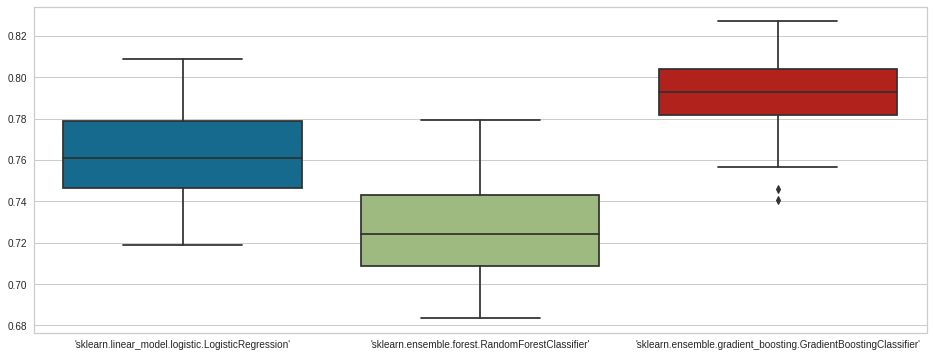

In [97]:
models_names = [re.findall(r"'[^'']*'", str(models[idx]))[0] for idx in range(len(models))]
plt.figure().set_size_inches(16, 6)
ax = sns.boxplot(x=models_names, y=all_scores)

#### **Grid search for selected hyperparameters**

In [116]:
parameters = {
    "learning_rate": [0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4],
    "max_depth":[2, 3, 5, 7],
    "n_estimators":[10, 50, 100, 150]
    }

In [117]:
%%time
model = GradientBoostingClassifier()
grid_log = GridSearchCV(model, param_grid=parameters, cv=10, refit=True, n_jobs=-1)
grid_log.fit(X_dev, y_dev)

CPU times: user 22.3 s, sys: 1.16 s, total: 23.4 s
Wall time: 25min 10s


In [155]:
print(grid_log.best_params_)

{'learning_rate': 0.075, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [118]:
final_model = grid_log.best_estimator_
scores = cross_val_score(final_model, X_dev, y_dev, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.03)


In [122]:
with open('final_model', 'wb') as f:
    pickle.dump(final_model, f, pickle.HIGHEST_PROTOCOL)

____

## VALIDATION & INTERPRETATION

In [157]:
X_train, X_test, y_train, y_test = train_test_split(x_dev, y_dev, test_size=0.2, random_state=123)
model = clone(grid_log.best_estimator_)
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.075, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
print(confusion_matrix(y_test, y_preds))

In [158]:
y_preds = model.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       632
           1       0.84      0.55      0.66       168

    accuracy                           0.88       800
   macro avg       0.87      0.76      0.80       800
weighted avg       0.88      0.88      0.87       800



#### **Precision vs Recall**

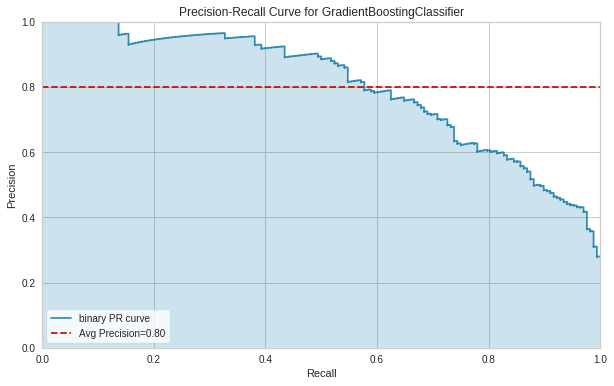

In [161]:
plt.figure().set_size_inches(10, 6)
viz = PrecisionRecallCurve(model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

#### **ROC Curves**

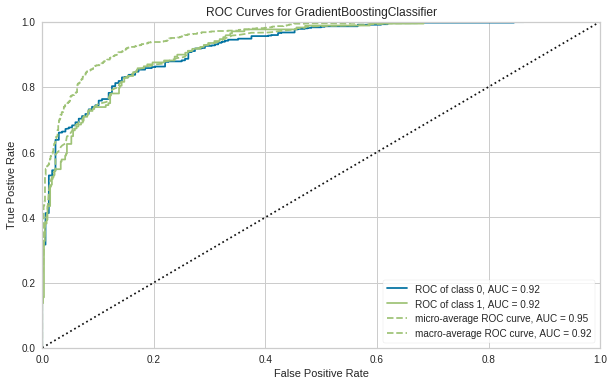

In [159]:
plt.figure().set_size_inches(10, 6)
visualizer = ROCAUC(model, classes=[0, 1])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

#### **Features importance**

In [167]:
clf = Pipeline(steps=[('preprocessor', full_pipe), ('regressor', LogisticRegression())])
_ = clf.fit(df, y_dev)
num_features = clf.named_steps['preprocessor'].transformers_[0][2]
cat_features = list(clf.named_steps['preprocessor'].transformers_[1][1].named_steps['one_hot'].get_feature_names())
feature_names = num_features + cat_features
assert(len(feature_names) == x_dev.shape[1])

['daily_commute', 'friends_number', 'education', 'age', 'texts_fitness_score', 'groups_count', 'days_since_last_join', 'x0_big_loc', 'x0_medium_loc', 'x0_small_loc', 'x1_not_sport', 'x1_sport', 'x2_not_same_location', 'x2_same_location', 'x3_not_squash', 'x3_squash', 'x4_not_tennis', 'x4_tennis', 'x5_fitness', 'x5_not_fitness', 'x6_American Express', 'x6_Mastercard', 'x6_Revolut', 'x6_Visa', 'x6_misasing', 'x7_not_weightlifting', 'x7_weightlifting', 'x8_female', 'x8_male', 'x9_big_loc_past', 'x9_medium_loc_past', 'x9_small_loc_past', 'x10_gym', 'x10_not_gym', 'x11_bike', 'x11_not_bike', 'x12_Divorced', 'x12_In relationship', 'x12_Married', 'x12_Married with kids', 'x12_Single', 'x12_misasing', 'x13_crossfit', 'x13_not_crossfit', 'x14_not_excercise', 'x15_bodybuilding', 'x15_not_bodybuilding']


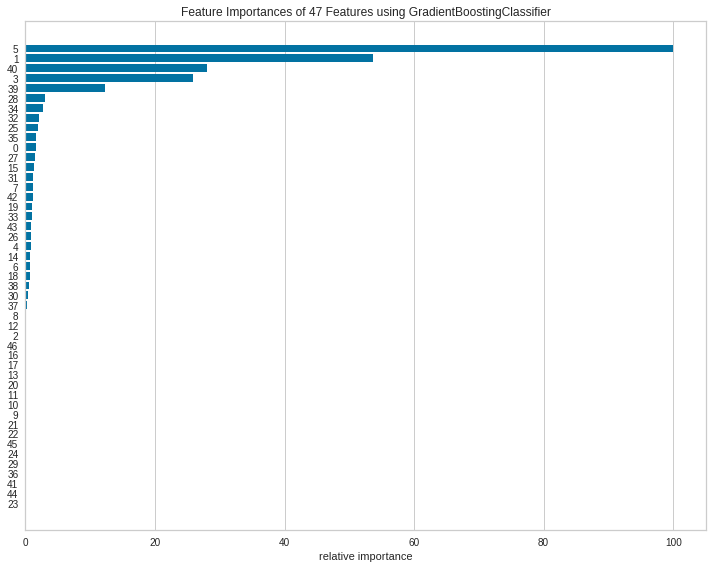

In [194]:
fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot()
viz = FeatureImportances(model, ax=ax)
viz.fit(X_train, y_train)
viz.poof()

In [195]:
ordered_features = [feature_names[idx] for idx in list(viz.features_)]
features_importance = list(viz.feature_importances_)
ordered_features.reverse(); features_importance.reverse()

In [196]:
pd.DataFrame({"feature_name": ordered_features, "feature_importance": features_importance}).head(10)

,feature_name,feature_importance
0,groups_count,100.000000
1,friends_number,53.730024
2,x12_Single,28.101298
3,age,25.933067
4,x12_Married with kids,12.249886
5,x8_male,3.065025
6,x11_bike,2.700563
7,x10_gym,2.155223
8,x7_not_weightlifting,1.881523
9,x11_not_bike,1.646528


____

## TEST PREDICTIONS

In [78]:
%%time
df_test = make_input_df(csv_path=test_csv,
                   json_path=train_json,
                   num_columns=num_columns,
                   fit_words=fit_words,
                   text_prep_filters=custom_filters)

CPU times: user 2min 37s, sys: 636 ms, total: 2min 38s
Wall time: 2min 38s


In [147]:
x_df_test = df_test.drop(['user_id', 'target', 'occupation', 'hobbies'], axis=1)
X_test = full_pipe.transform(x_df_test)
assert(x_dev.shape[1] == X_test.shape[1])
print(X_test.shape)

(2000, 47)


In [154]:
submission = pd.DataFrame(columns=['user_id', 'prob', 'pred'])
submission['user_id'] = df_test['user_id']
submission['prob'] = final_model.predict_proba(X_test)
submission['pred'] = final_model.predict(X_test)
submission.to_csv("test_predictions.csv", index=False)

<center>THE END</center>